# Task 2: Recommendation Engine - Skeleton Notebook

This notebook provides a very basic example for the notebook you are expected to submit for Task 2 of the Final Project. The main purpose is that we can try different examples to get a better sense of your approach. Compared to Task 1 (Kaggle Competition), we don't have any objective means to evaluate the recommendations. 

Some general comments:
* You can import any data you need. This particularly includes your cleaned version of the properties dataset (incl. the auxiliary data or any other data you might have collected); there's no need to show the data cleaning / preprocessing steps in this notebook.
* You can also import your code in form of external Python (.py) script. You're actually encouraged to do so to keep this notebook light and uncluttered.
* **Important:** Please consider this notebook as an example and not to set specific requirements. Your notebook is likely to look very different. As long there is a section where we can easily test your solution, it should be fine.

## Setting up the Notebook

In [1]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing

## Load the Data

Loading our encoded train dataset for the recommendation task

In [2]:
df = pd.read_csv('../data/train_encoded_1_task2.csv')

In [3]:
df.columns

Index(['num_beds', 'num_baths', 'size_sqft', 'lat', 'lng', 'price',
       'built_year', 'pri_sch', 'sec_sch', 'mrt_station', 'population_density',
       'closest_dist_to_mrt', 'closest_dist_to_pri', 'closest_dist_to_sec',
       'close_pri_sch', 'close_sec_sch', 'closest_dist_to_shop',
       'closest_dist_to_com', 'price_per_sqft', 'price_avg_planning_area',
       'psf_bbox', 'age', 'property_type_cluster house', 'property_type_condo',
       'property_type_corner terrace', 'property_type_executive condo',
       'property_type_hdb', 'property_type_semi-detached house',
       'property_type_terraced house', 'property_type_infrequent_sklearn',
       'furnishing_partial', 'furnishing_unfurnished',
       'furnishing_unspecified', 'furnishing_infrequent_sklearn',
       'tenure_999-year leasehold', 'tenure_freehold'],
      dtype='object')

In [4]:
df['id'] = df.index

#### Using min_max to normalise the dataframe to make all dataset columns lie in the same scale

In [5]:
prop_num = df[['lat','lng','num_beds', 'num_baths', 'size_sqft', 'price', 'built_year', 'pri_sch',
       'sec_sch', 'mrt_station', 'population_density', 'closest_dist_to_mrt',
       'closest_dist_to_pri', 'closest_dist_to_sec', 'close_pri_sch',
       'close_sec_sch', 'closest_dist_to_shop', 'closest_dist_to_com',
       'price_per_sqft', 'price_avg_planning_area', 'psf_bbox', 'age',
       'property_type_cluster house', 'property_type_condo',
       'property_type_corner terrace', 'property_type_executive condo',
       'property_type_hdb', 'property_type_semi-detached house',
       'property_type_terraced house', 'property_type_infrequent_sklearn',
       'furnishing_partial', 'furnishing_unfurnished',
       'furnishing_unspecified', 'furnishing_infrequent_sklearn',
       'tenure_999-year leasehold', 'tenure_freehold']]

prop_data = []
for i in range(df.shape[0]):
    temp = []
    for j in range(df.shape[1]-1):
        temp.append(list(prop_num.iloc[i])[j])
    prop_data.append(temp)
df_prop = pd.DataFrame(prop_data)
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_prop)
df_normalized = pd.DataFrame(np_scaled)
ls = df_normalized.values.tolist()
df_normalized.head(10)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.599096,0.606445,0.333333,0.111111,0.017555,0.006469,0.230769,0.166667,0.0,0.00,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.266496,0.671583,0.333333,0.555556,0.034936,0.071454,0.907692,0.000000,0.2,0.00,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.327728,0.372822,0.222222,0.111111,0.010382,0.020617,0.923077,0.166667,0.2,0.25,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.154702,0.503155,0.111111,0.000000,0.007754,0.013138,0.969231,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.449256,0.245676,0.111111,0.111111,0.007255,0.012600,0.938462,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5,0.319964,0.530646,0.222222,0.111111,0.011754,0.019315,0.969231,0.166667,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,0.462781,0.312178,0.444444,0.555556,0.132942,0.133580,0.676923,0.000000,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7,0.342014,0.445193,0.000000,0.000000,0.007382,0.009220,0.784615,0.000000,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.319012,0.371370,0.111111,0.000000,0.005871,0.013472,0.953846,0.000000,0.0,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
9,0.371831,0.831170,0.111111,0.111111,0.019392,0.016964,0.338462,0.333333,0.6,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Getting the relevant NORMALISED row using ID

In [6]:
def data_select(id):
    row_index = list(df['id']).index(id)
    prop_select = ls[row_index]
    return prop_select

#### Using Cosine distance and Euclidean distance to find similarity between two entities when projected in a multidimensional space

In [7]:
def cosine_similarity(v1, v2):
    return dot(v1, v2)/(norm(v1)*norm(v2))

In [29]:
def euclidean_similarity(v1, v2):
    euclid = distance.euclidean(v1,v2)
    result = 1/(1+euclid)
    return result

#### Calling cosine_similarity function to comapre target with all other rows in dataframe

In [30]:
def recommend_list(target):
    similarities = []
    for i in range(df.shape[0]):
        item = []
        item.append(i)
        #item.append(cosine_similarity(target, ls[i]))
        item.append(euclidean_similarity(target, ls[i]))
        similarities.append(item)
    return similarities

## Computing the Top Recommendations

The method `get_top_recommendations()` shows an example of how to get the top recommendations for a given data sample (data sample = row in the dataframe of the dataset). The input is a row from the dataset and a list of optional input parameters which will depend on your approach; `k` is the number of returned recommendations seems useful, though.

The output should be a `pd.DataFrame` containing the recommendations. The output dataframe should have the same columns as the row + any additional columns you deem important (e.g., any score or tags that you might want to add to your recommendations).

In principle, the method `get_top_recommendations()` may be imported from a external Python (.py) script as well.

In [35]:
def get_top_recommendations(row, **kwargs) -> pd.DataFrame:
    
    #####################################################
    ## Initialize the required parameters
    
    # The number of recommendations seem recommended
    # Additional input parameters are up to you
    k = None
    
    # Extract all **kwargs input parameters
    # and set the used paramaters (here: k)
    for key, value in kwargs.items():
        if key == 'k':
            k = value
            
       
    #####################################################
    ## Compute your recommendations
    #
    # This is where your magic happens. Of course, you can call methods
    # defined in this notebook or in external Python (.py) scripts
    #
    
    
    row_id = row['id']
    price = row['price']
    target = data_select(row_id)
    result = recommend_list(target)
    result_list = DataFrame.from_records(result)
    result_list = result_list.sort_values(by=[1], ascending=False)
    topk_index = list(result_list[0])
    topk_index.remove(row_id)
    df_ret = df.loc[topk_index, :]
    df_ret = df_ret[df_ret['price']<price]
    df_ret.drop_duplicates(subset=['lat','lng'],inplace=True)
    
        
    # Here, we just return the input row k times
    # Ideally, you recommendations will be much better
    #df_result = pd.DataFrame([row] * k, index=None)
        
    # Return the dataset with the k recommendations
    return df_ret


## Testing the Recommendation Engine

This will be the main part of your notebook to allow for testing your solutions. Most basically, for a given listing (defined by the row id in your input dataframe), we would like to see the recommendations you make. So however you set up your notebook, it should have at least a comparable section that will allow us to run your solution for different inputs.

### Pick a Sample Listing as Input

In [36]:
# Pick a row id of choice
#row_id = 10
#row_id = 20
#row_id = 30
row_id = 40
#row_id = 50

# Get the row from the dataframe (an valid row ids will throw an error)
row = df.iloc[row_id]

# Just for printing it nicely, we create a new dataframe from this single row
pd.DataFrame([row])

,num_beds,num_baths,size_sqft,lat,lng,price,built_year,pri_sch,sec_sch,mrt_station,...,property_type_semi-detached house,property_type_terraced house,property_type_infrequent_sklearn,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,furnishing_infrequent_sklearn,tenure_999-year leasehold,tenure_freehold,id
40,3.0,2.0,1130.0,1.335917,103.936944,648900.0,2000.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0


## Compute and Display the recommendations

Since the method `get_top_recommendations()` returns a `pd.DataFrame`, it's easy to display the result.

In [37]:
k = 10

df_recommendations = get_top_recommendations(row, k=k)

df_recommendations.head(k)

,num_beds,num_baths,size_sqft,lat,lng,price,built_year,pri_sch,sec_sch,mrt_station,...,property_type_semi-detached house,property_type_terraced house,property_type_infrequent_sklearn,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,furnishing_infrequent_sklearn,tenure_999-year leasehold,tenure_freehold,id
4428,3.0,2.0,1130,1.336399,103.937362,588000.0,2000.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,4428
16244,3.0,2.0,1238,1.336029,103.938165,629000.0,2000.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,16244
12850,3.0,2.0,1109,1.337127,103.928415,617400.0,1984.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,12850
7050,3.0,2.0,1130,1.366824,103.950288,546000.0,1988.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,7050
1122,3.0,2.0,1324,1.368581,103.949825,627900.0,1988.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,1122
11008,3.0,2.0,904,1.328122,103.904524,522900.0,1985.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,11008
5351,3.0,2.0,1129,1.328225,103.904109,598500.0,1985.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,5351
9370,3.0,2.0,1119,1.329143,103.903505,535500.0,1985.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,9370
8698,3.0,2.0,904,1.328556,103.903391,512400.0,1985.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,8698
11199,3.0,2.0,968,1.328173,103.903496,503800.0,1985.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,0,11199


#### To get the max/min lat/lng values

In [38]:
df_recommendations.describe()

,num_beds,num_baths,size_sqft,lat,lng,price,built_year,pri_sch,sec_sch,mrt_station,...,property_type_semi-detached house,property_type_terraced house,property_type_infrequent_sklearn,furnishing_partial,furnishing_unfurnished,furnishing_unspecified,furnishing_infrequent_sklearn,tenure_999-year leasehold,tenure_freehold,id
count,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,1290.000000,...,1290.0,1290.0,1290.0,1290.000000,1290.000000,1290.000000,1290.0,1290.0,1290.00000,1290.000000
mean,2.616279,1.884496,909.863566,1.368089,103.841541,506911.395349,1990.059690,1.724031,1.205426,0.544961,...,0.0,0.0,0.0,0.048062,0.040310,0.896899,0.0,0.0,0.00155,9337.772868
std,0.567451,0.340890,206.903833,0.045180,0.064896,92707.407136,17.223858,1.438621,1.032656,0.865641,...,0.0,0.0,0.0,0.213980,0.196762,0.304208,0.0,0.0,0.03936,5302.365579
min,1.000000,1.000000,92.000000,1.271743,103.687807,250800.000000,1967.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.00000,14.000000
25%,2.000000,2.000000,721.000000,1.333165,103.794523,420000.000000,1975.000000,1.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.00000,5024.500000
50%,3.000000,2.000000,969.000000,1.367993,103.848989,524000.000000,1984.000000,2.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.00000,9358.500000
75%,3.000000,2.000000,1012.000000,1.398427,103.895204,588000.000000,2008.000000,2.000000,2.000000,1.000000,...,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.00000,13780.500000
max,5.000000,5.000000,1560.000000,1.456467,103.987631,645800.000000,2019.000000,6.000000,5.000000,3.000000,...,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.00000,18408.000000


### Using scatter-plot to plot the different properties on SG map using bounding box to set the upper limit of lng/lat values

/opt/anaconda3/envs/wp4/lib/python3.9/site-packages/matplotlib/collections.py:1120: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


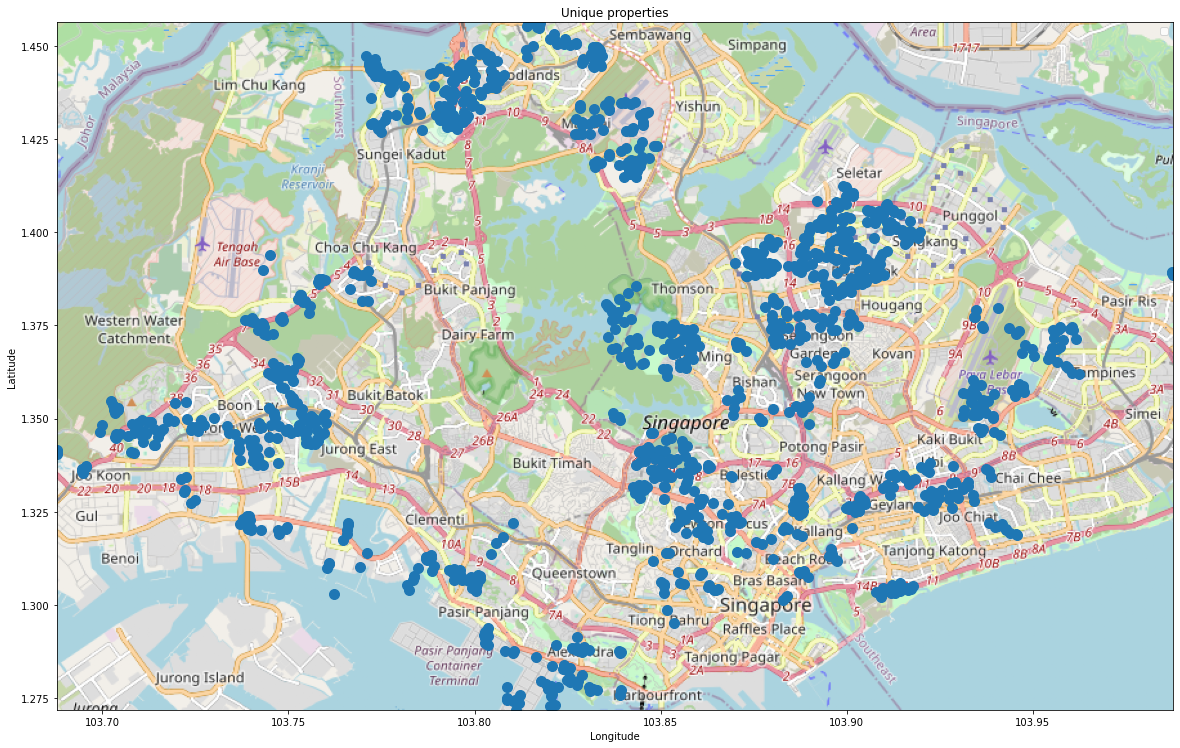

In [39]:
sg_map = plt.imread('images/map_sg.png')
BBox = [103.687807, 103.987631, 1.271743,1.456467]

fig, ax = plt.subplots(figsize = (20,21))
ax.imshow(sg_map, zorder=0, extent=BBox, aspect="equal")
scatter_plot=ax.scatter(data=df_recommendations, x="lng", y="lat",s=100.0,cmap="magma")
ax.set(title=f'Unique properties',xlabel="Longitude",ylabel="Latitude")
ax.legend(*scatter_plot.legend_elements())

### Plotting top-10 recommendations on the SG map

<function matplotlib.pyplot.show(close=None, block=None)>

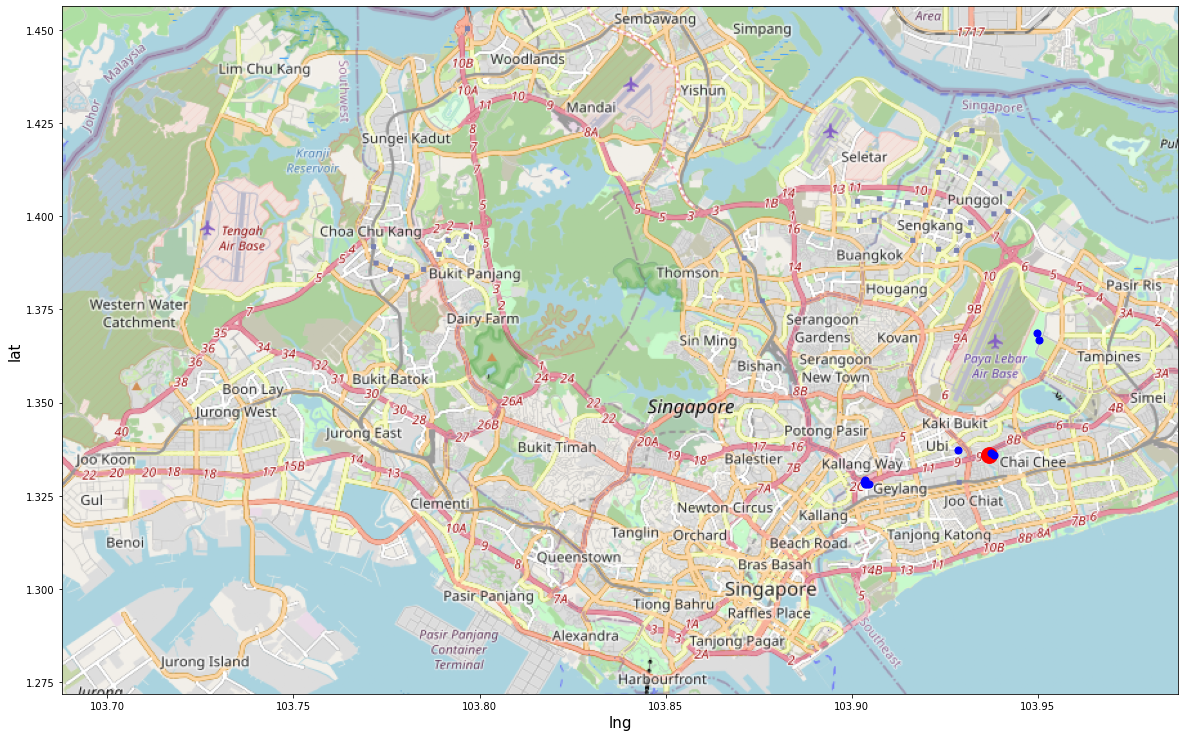

In [40]:
df_rec = df_recommendations.head(k)

sg_map = plt.imread('images/map_sg.png')
BBox = [103.687807, 103.987631, 1.271743,1.456467]

fig, ax = plt.subplots(figsize = (20,21))
ax.imshow(sg_map, zorder=0, extent=BBox, aspect="equal")
plt.scatter(data=row, x="lng", y="lat",s=250.0,c="red")
plt.scatter(data=df_rec, x="lng", y="lat",s=50.0,c="blue")
plt.xlabel("lng",fontdict={'size':15})
plt.ylabel("lat",fontdict={'size':15})
plt.show